In [5]:


import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [6]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [7]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [8]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [10]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [14]:
images,target=next(iter(train_gen))
images.shape


(32, 224, 224, 3)

In [7]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [8]:

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.layers import GlobalAveragePooling2D

In [9]:
# model=Sequential()


In [10]:
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",padding ='same', input_shape=(224,224,3)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=128, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=256, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,kernel_size=(1, 1),padding ='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",padding ='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=128, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=256, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,kernel_size=(1, 1),padding ='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",padding ='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=128, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=256, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,kernel_size=(1, 1),padding ='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu",padding ='same'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=64, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=128, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=256, kernel_size=(3, 3),padding ='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,kernel_size=(1, 1),padding ='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
# model.add(GlobalAveragePooling2D())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 218, 218, 128)     73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 216, 216, 256)     295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 108, 108, 256)     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 106, 106, 32)      7376

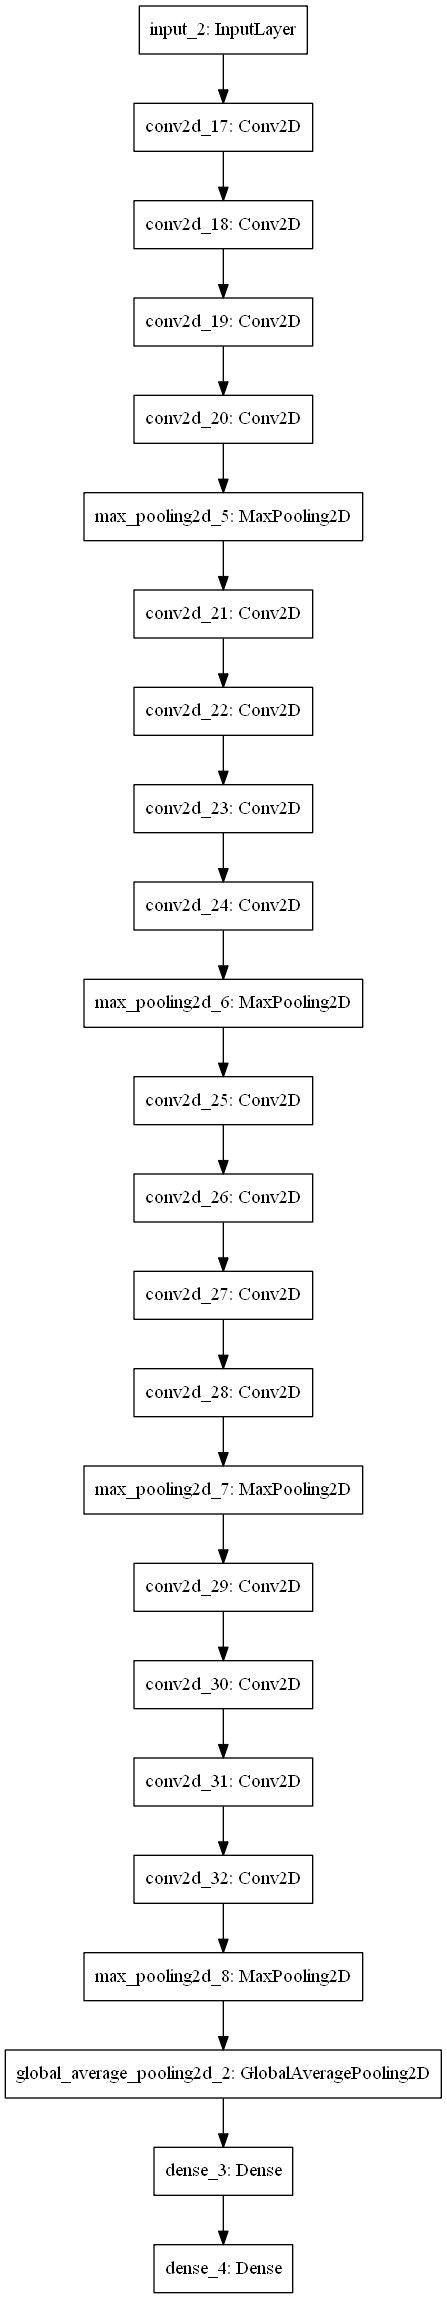

In [12]:

# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
sequential_Input = Input(shape=(224,224,3))
Sequential_NN1_1=Conv2D(32, kernel_size=3, activation='relu')(sequential_Input)
Sequential_NN1_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN1_1)
Sequential_NN1_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN1_2)
Sequential_NN1_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN1_3)
Sequential_NN_pool1= MaxPooling2D()(Sequential_NN1_4)

Sequential_NN2_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN_pool1)
Sequential_NN2_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN2_1)
Sequential_NN2_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN2_2)
Sequential_NN2_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN2_3)
Sequential_NN_pool2= MaxPooling2D()(Sequential_NN2_4)

Sequential_NN3_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN_pool2)
Sequential_NN3_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN3_1)
Sequential_NN3_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN3_2)
Sequential_NN3_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN3_3)
Sequential_NN_pool3= MaxPooling2D()(Sequential_NN3_4)

Sequential_NN4_1=Conv2D(32, kernel_size=3, activation='relu')(Sequential_NN_pool3)
Sequential_NN4_2=Conv2D(64, kernel_size=3, activation='relu')(Sequential_NN4_1)
Sequential_NN4_3=Conv2D(128, kernel_size=3, activation='relu')(Sequential_NN4_2)
Sequential_NN4_4=Conv2D(256, kernel_size=3, activation='relu')(Sequential_NN4_3)
Sequential_NN_pool4= MaxPooling2D()(Sequential_NN4_4)

Sequential_NN_GAP=GlobalAveragePooling2D()(Sequential_NN_pool4)
Sequential_NN_Dense1=Dense(512, activation='relu')(Sequential_NN_GAP)
Output=Dense(256, activation='softmax')(Sequential_NN_Dense1)

backbone = Model(inputs=sequential_Input, outputs=Output)
print(backbone.summary())

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(backbone, to_file='convolutional_neural_network.png')

In [13]:
neck = backbone.output
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


In [14]:
Dhruv_net = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 222, 222, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 220, 220, 64) 18496       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 218, 218, 128 73856       conv2d_18[0][0]                  
____________________________________________________________________________________________

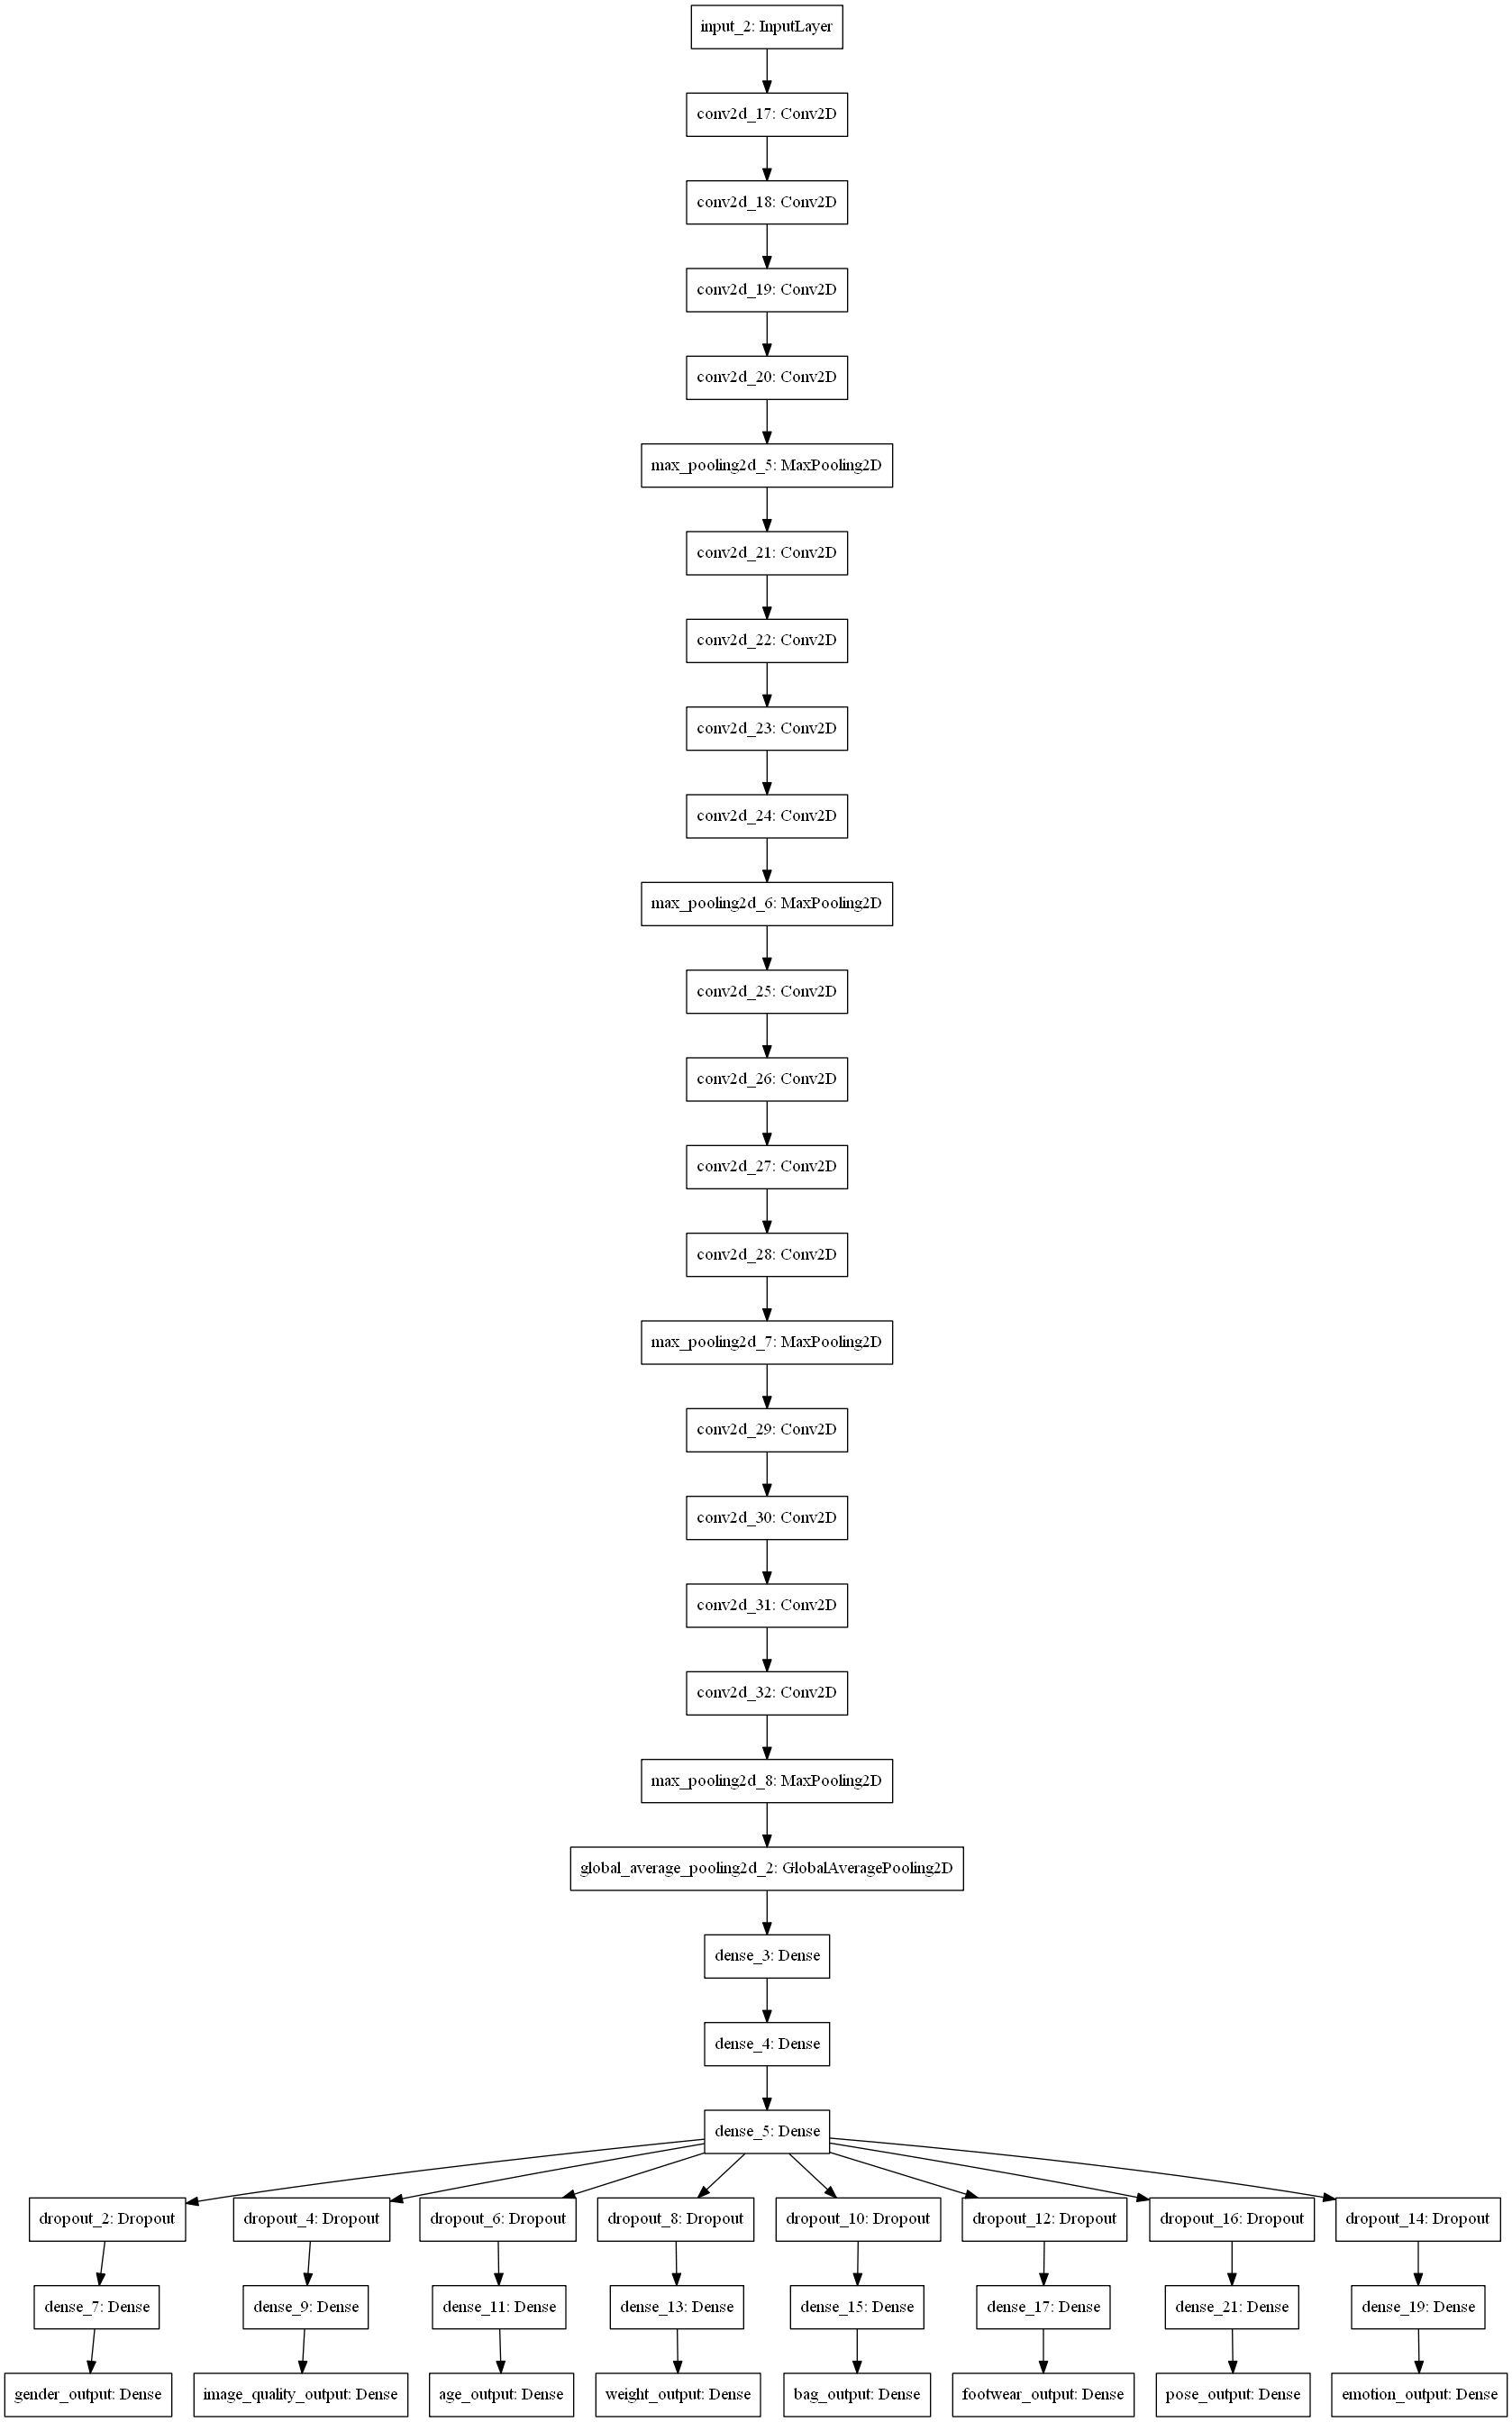

In [15]:
print(Dhruv_net.summary())

# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# plot graph
plot_model(Dhruv_net, to_file='convolutional_neural_network.png')

In [16]:
opt = SGD(lr=0.01, momentum=0.9,decay=1e-2/epochs)
Dhruv_net.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [3]:
epochs=5
lrs = [self(i) for i in range(epochs)]
 
# the learning rate schedule
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, lrs)
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Learning Rate")

NameError: name 'self' is not defined

In [17]:
Dhruv_net.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=5,

)

Epoch 1/10
360/360 [==============================] - 12166s 34s/step - loss: 8.2564 - gender_output_loss: 0.6864 - image_quality_output_loss: 1.0074 - age_output_loss: 1.4937 - weight_output_loss: 1.0841 - bag_output_loss: 0.9583 - footwear_output_loss: 1.0536 - pose_output_loss: 0.9538 - emotion_output_loss: 1.0190 - gender_output_accuracy: 0.5640 - image_quality_output_accuracy: 0.5516 - age_output_accuracy: 0.3924 - weight_output_accuracy: 0.6332 - bag_output_accuracy: 0.5651 - footwear_output_accuracy: 0.4440 - pose_output_accuracy: 0.6182 - emotion_output_accuracy: 0.7042 - val_loss: 8.0898 - val_gender_output_loss: 0.6851 - val_image_quality_output_loss: 0.9832 - val_age_output_loss: 1.4398 - val_weight_output_loss: 0.9887 - val_bag_output_loss: 0.9181 - val_footwear_output_loss: 1.0387 - val_pose_output_loss: 0.9228 - val_emotion_output_loss: 0.9094 - val_gender_output_accuracy: 0.5636 - val_image_quality_output_accuracy: 0.5526 - val_age_output_accuracy: 0.3964 - val_weight_ou

KeyboardInterrupt: 